In [331]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import pandas as pd

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from yellowbrick.cluster import SilhouetteVisualizer

In [332]:
df = pd.read_csv("sqlized_superstore.csv")

In [48]:
df.head()

,CustomerName,CustomerID,Segment,City,State,Region,Country,PostalCode,OrderID,OrderDate,ShipDate,ShipMode,Sales,Discount,Profit,Quantity,ProductName,Category,SubCategory
0,Claire Gute,CG-12520,Consumer,Henderson,Kentucky,South,United States,42420,CA-2016-152156,2016-11-08,2016-11-11,Second Class,"261,96","0,0","41,9136",2,Bush Somerset Collection Bookcase,Furniture,Bookcases
1,Claire Gute,CG-12520,Consumer,Henderson,Kentucky,South,United States,42420,CA-2016-152156,2016-11-08,2016-11-11,Second Class,"731,94","0,0","219,582",3,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",Furniture,Chairs
2,Darrin Van Huff,DV-13045,Corporate,Los Angeles,California,West,United States,90036,CA-2016-138688,2016-06-12,2016-06-16,Second Class,"14,62","0,0","6,8714",2,Self-Adhesive Address Labels for Typewriters b...,Office Supplies,Labels
3,Sean O'Donnell,SO-20335,Consumer,Fort Lauderdale,Florida,South,United States,33311,US-2015-108966,2015-10-11,2015-10-18,Standard Class,"957,5775","0,45","-383,031",5,Bretford CR4500 Series Slim Rectangular Table,Furniture,Tables
4,Sean O'Donnell,SO-20335,Consumer,Fort Lauderdale,Florida,South,United States,33311,US-2015-108966,2015-10-11,2015-10-18,Standard Class,"22,368","0,2","2,5164",2,Eldon Fold 'N Roll Cart System,Office Supplies,Storage


In [49]:
# Convert 'Sales' column to numeric after replacing commas and summing up
total_sales = df['Sales'].str.replace(',', '.', regex=False).astype(float).sum()
print("Total sum of sales:", total_sales)

Total sum of sales: 2297200.8603000003


In [50]:
total_sales_int = int(total_sales)
print("Total sum of sales (integer):", total_sales_int)

Total sum of sales (integer): 2297200


In [ ]:
# Filter orders from 2017 and sum their sales
df_2017 = df[df['OrderDate'].str.startswith('2017')]
total_sales_2017 = df_2017['Sales_numeric'].sum()
print("Total sales for 2017:", total_sales_2017)

Total sales for 2017: 733215.2552


In [333]:
df['Sales_numeric'] = df['Sales'].str.replace(',', '.', regex=False).astype(float)

## Create a new dataframe

In [334]:
df_monetary = df.groupby('CustomerID', as_index=False)['Sales_numeric'].sum()
df_monetary.rename(columns={'Sales_numeric': 'monetary'}, inplace=True)
df_monetary.head()

,CustomerID,monetary
0,AA-10315,5563.560
1,AA-10375,1056.390
2,AA-10480,1790.512
3,AA-10645,5086.935
4,AB-10015,886.156


In [335]:
df_frequency = df.groupby('CustomerID', as_index=False)['OrderDate'].count()
df_frequency.rename(columns={'OrderDate': 'frequency'}, inplace=True)
df_frequency.head()

,CustomerID,frequency
0,AA-10315,11
1,AA-10375,15
2,AA-10480,12
3,AA-10645,18
4,AB-10015,6


In [336]:
# Ensure OrderDate is datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

# Set a reference date (e.g., max date in dataset or today)
reference_date = df['OrderDate'].max()

# Compute most recent purchase date per customer
df_recency = df.groupby('CustomerID', as_index=False)['OrderDate'].max()
df_recency.rename(columns={'OrderDate': 'LastPurchaseDate'}, inplace=True)

# Calculate recency in days
df_recency['recency'] = (reference_date - df_recency['LastPurchaseDate']).dt.days

# Drop 'LastPurchaseDate' if you only need 'recency'
df_recency.drop(columns='LastPurchaseDate', inplace=True)

df_recency.head()


,CustomerID,recency
0,AA-10315,184
1,AA-10375,19
2,AA-10480,259
3,AA-10645,55
4,AB-10015,415


In [337]:
# Merge recency, frequency, and monetary dataframes on 'CustomerID'
rfm = df_recency.merge(df_frequency, on='CustomerID').merge(df_monetary, on='CustomerID')
rfm.head()

,CustomerID,recency,frequency,monetary
0,AA-10315,184,11,5563.560
1,AA-10375,19,15,1056.390
2,AA-10480,259,12,1790.512
3,AA-10645,55,18,5086.935
4,AB-10015,415,6,886.156


In [338]:
rfm.to_csv("rfm.csv", index=False)

## Identifying outliers

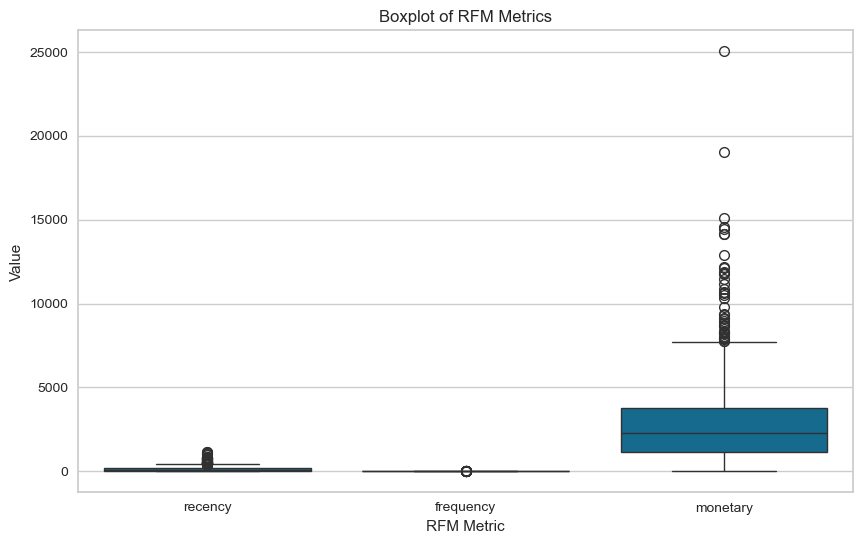

In [339]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape the dataframe from wide to long format
rfm_melted = rfm.melt(id_vars='CustomerID',
                    value_vars=['recency', 'frequency', 'monetary'],
                    var_name='Metric', value_name='Value')

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Value', data=rfm_melted)

plt.title('Boxplot of RFM Metrics')
plt.xlabel('RFM Metric')
plt.ylabel('Value')
plt.show()


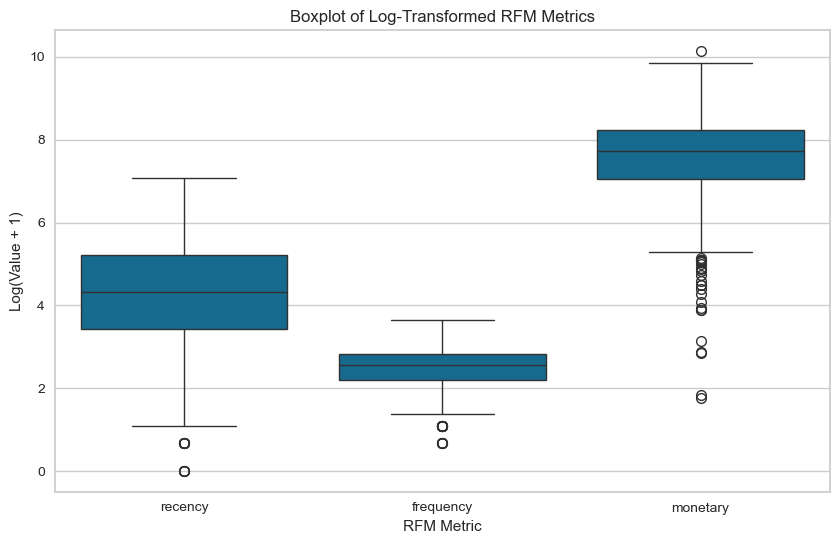

In [340]:
import numpy as np

# Create a log-transformed version
rfm_log = rfm.copy()
rfm_log[['recency', 'frequency', 'monetary']] = rfm_log[['recency', 'frequency', 'monetary']].apply(np.log1p)

# Melt and plot again
rfm_melted_log = rfm_log.melt(id_vars='CustomerID',
                              value_vars=['recency', 'frequency', 'monetary'],
                              var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Value', data=rfm_melted_log)

plt.title('Boxplot of Log-Transformed RFM Metrics')
plt.xlabel('RFM Metric')
plt.ylabel('Log(Value + 1)')
plt.show()


## Removing outliers using IQR

In [341]:
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Apply to recency, frequency, monetary
rfm_no_outliers = remove_outliers_iqr(rfm, ['recency', 'frequency', 'monetary'])

# Check how many rows were removed
print(f"Original shape: {rfm.shape}")
print(f"Shape after outlier removal: {rfm_no_outliers.shape}")


Original shape: (793, 4)
Shape after outlier removal: (670, 4)


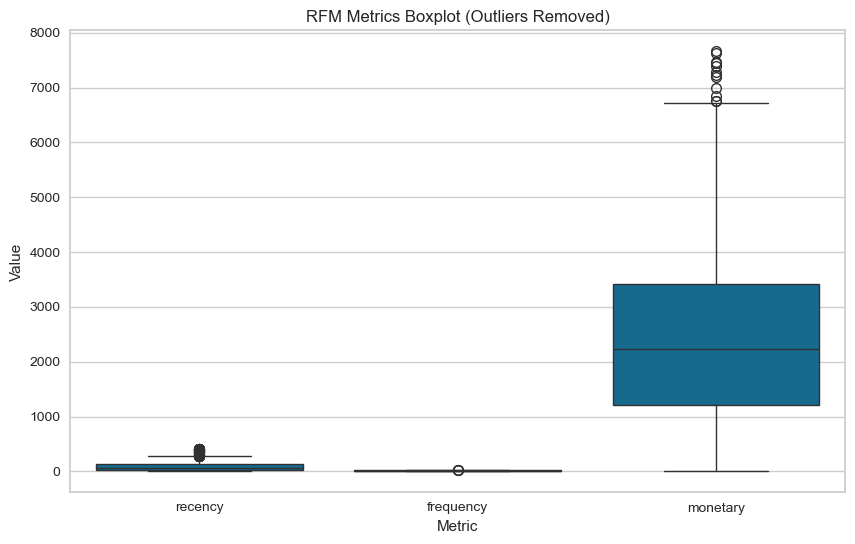

In [342]:
import seaborn as sns
import matplotlib.pyplot as plt

rfm_melted_no_outliers = rfm_no_outliers.melt(id_vars='CustomerID',
                                              value_vars=['recency', 'frequency', 'monetary'],
                                              var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Value', data=rfm_melted_no_outliers)
plt.title('RFM Metrics Boxplot (Outliers Removed)')
plt.show()


## Feature scaling

In [343]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Use the already cleaned DataFrame (from previous step)
rfm_features = rfm_no_outliers[['monetary', 'frequency', 'recency']]

# Instantiate the scaler
scaler = StandardScaler()

# Fit and transform the features
rfm_scaled_array = scaler.fit_transform(rfm_features)

# Convert back to DataFrame
rfm_scaled = pd.DataFrame(rfm_scaled_array, columns=['monetary', 'frequency', 'recency'])

# Preview
rfm_scaled.head()



,monetary,frequency,recency
0,1.805051,-0.269767,0.878322
1,-0.865214,0.450329,-0.812111
2,-0.430285,-0.089743,1.646700
3,1.522675,0.990401,-0.443290
4,-0.918345,-0.089743,-0.586720


## Build the model

In [344]:
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")


In [345]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_scaled)

KMeans(max_iter=50, n_clusters=4)

In [346]:
from collections import Counter
# Assign the labels to each data point, and execute the following script.
kmeans.labels_
label_list=kmeans.labels_
sorted(Counter(label_list).items())

[(0, 102), (1, 250), (2, 215), (3, 103)]

## Finding the optimal number of clusters

### The Elbow Method

Text(0.5, 1.0, 'Elbow Method For Optimal k')

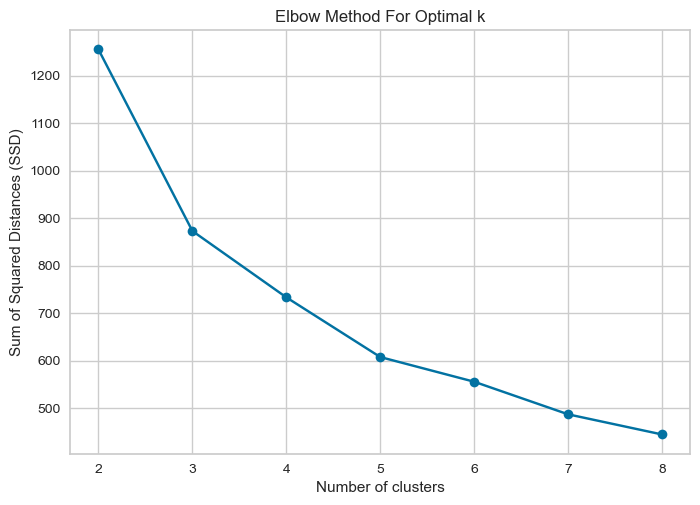

In [347]:
# Elbow-curve /SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_scaled)

    ssd.append(kmeans.inertia_)

# plot the SSDs for each n_clusters
plt.plot(range_n_clusters, ssd, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Distances (SSD)')
plt.title('Elbow Method For Optimal k')



### Silhouette Analysis

In [348]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_scaled)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))


For n_clusters=2, the silhouette score is 0.3393182549943759
For n_clusters=3, the silhouette score is 0.36321013764332005
For n_clusters=4, the silhouette score is 0.3205124443724729
For n_clusters=5, the silhouette score is 0.32960911312806845
For n_clusters=6, the silhouette score is 0.3275359891542923
For n_clusters=7, the silhouette score is 0.27796799911105496
For n_clusters=8, the silhouette score is 0.27963704330598754


In [349]:
# Calculate silhouette scores for each number of clusters (2017 data)
silhouette_scores = []
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    silhouette_scores.append({'n_clusters': num_clusters, 'silhouette_score': score})

# Convert to DataFrame for display
silhouette_df = pd.DataFrame(silhouette_scores)
silhouette_df

,n_clusters,silhouette_score
0,2,0.339318
1,3,0.362212
2,4,0.320512
3,5,0.332546
4,6,0.329929
5,7,0.276480
6,8,0.271345


In [351]:
k_clusters = 3 # increment to compare different cluster #s
kmeans = KMeans(n_clusters=k_clusters, random_state=420) 
silhouette_avg = silhouette_score(rfm_scaled, kmeans.fit_predict(rfm_scaled))
silhouette_avg

0.3622117530180901

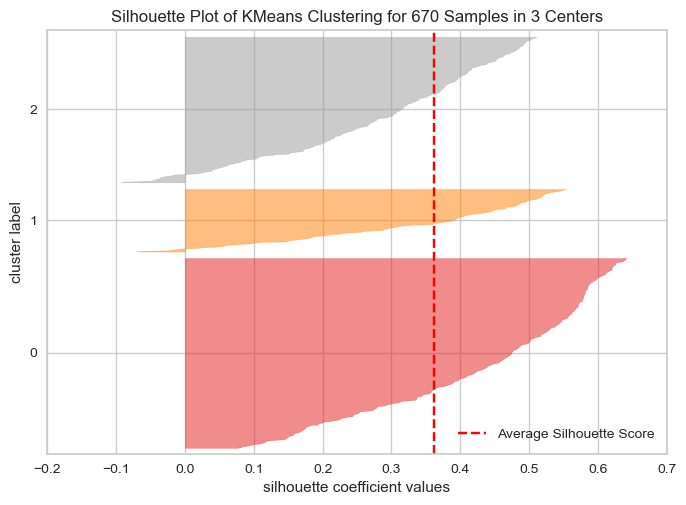

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 670 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [352]:
# Re-instantiate KMeans for yellowbrick (unfitted)
kmeans_viz = KMeans(n_clusters=k_clusters, random_state=420)
visualizer = SilhouetteVisualizer(kmeans_viz)
visualizer.fit(rfm_scaled)
visualizer.show()

## Train the model

In [353]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(rfm_scaled)


KMeans(n_clusters=3, random_state=42)

In [354]:
# assign the label
rfm_no_outliers['Cluster_Id'] = kmeans.labels_
rfm_no_outliers.head()



,CustomerID,recency,frequency,monetary,Cluster_Id
0,AA-10315,184,11,5563.560,2
1,AA-10375,19,15,1056.390,0
2,AA-10480,259,12,1790.512,1
3,AA-10645,55,18,5086.935,2
7,AB-10150,41,12,966.710,0


<Axes: xlabel='Cluster_Id', ylabel='monetary'>

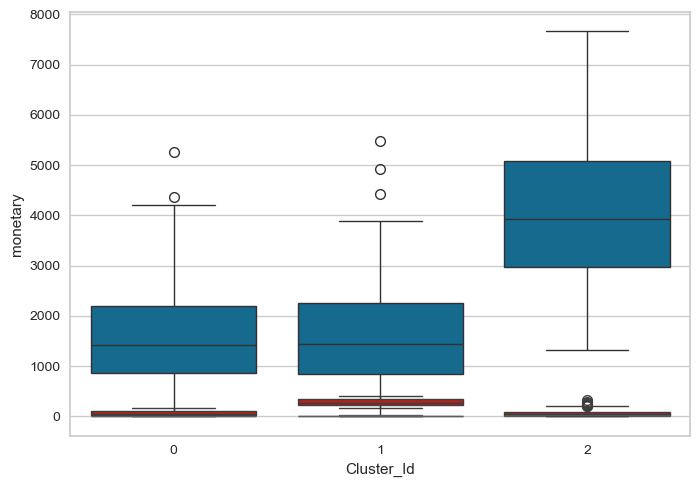

In [355]:
# Box plot to visualize Cluster Id vs Monetary
sns.boxplot(x='Cluster_Id', y='monetary', data=rfm_no_outliers)

# Box plot to visualize Cluster Id vs Frequency
sns.boxplot(x='Cluster_Id', y='frequency', data=rfm_no_outliers)

# Box plot to visualize Cluster Id vs Recency
sns.boxplot(x='Cluster_Id', y='recency', data=rfm_no_outliers)


In [356]:
rfm_no_outliers.groupby('Cluster_Id')[['recency', 'frequency', 'monetary']].mean()

,recency,frequency,monetary
Cluster_Id,,,
0,63.667712,9.463950,1584.050692
1,282.622642,9.650943,1601.872279
2,63.559184,17.681633,4127.109264


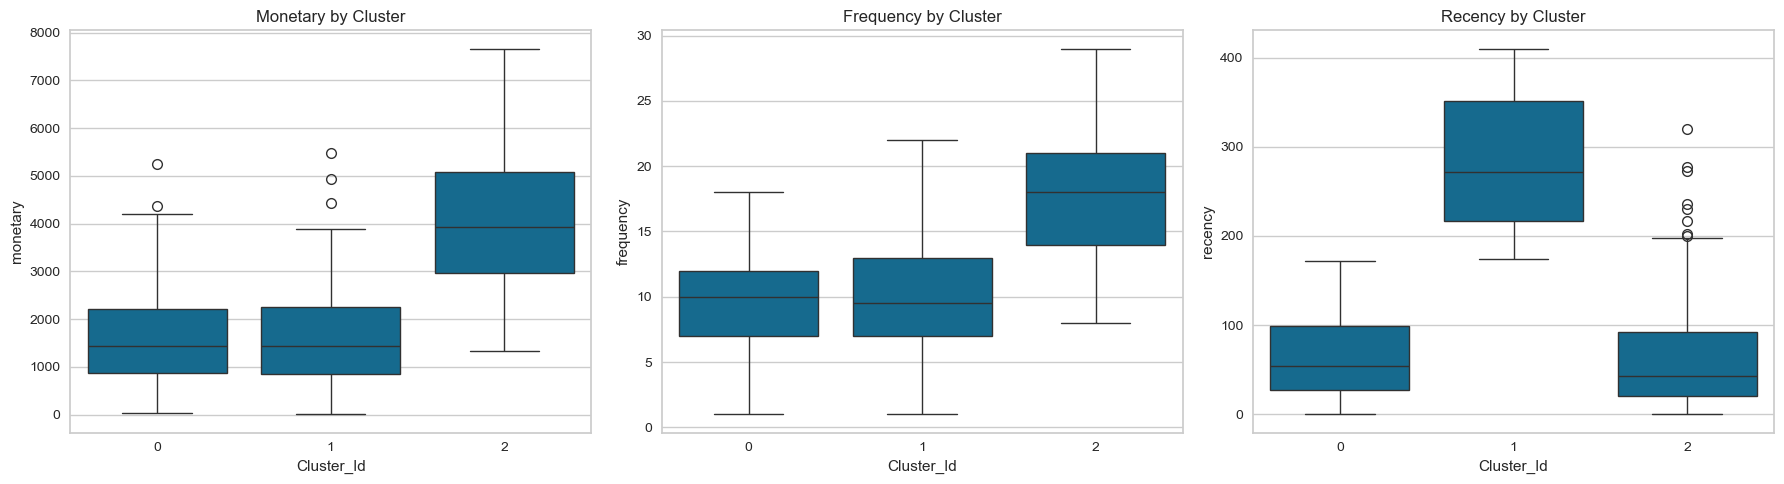

In [357]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting space: 1 row, 3 columns
plt.figure(figsize=(18, 5))

# Monetary
plt.subplot(1, 3, 1)
sns.boxplot(x='Cluster_Id', y='monetary', data=rfm_no_outliers)
plt.title('Monetary by Cluster')

# Frequency
plt.subplot(1, 3, 2)
sns.boxplot(x='Cluster_Id', y='frequency', data=rfm_no_outliers)
plt.title('Frequency by Cluster')

# Recency
plt.subplot(1, 3, 3)
sns.boxplot(x='Cluster_Id', y='recency', data=rfm_no_outliers)
plt.title('Recency by Cluster')

# Layout adjustment
plt.tight_layout()
plt.show()


In [358]:
# Group by cluster and calculate the mean of RFM values
cluster_summary = rfm_no_outliers.groupby('Cluster_Id')[['recency', 'frequency', 'monetary']].mean()

# Add customer count per cluster
cluster_summary['num_customers'] = rfm_no_outliers['Cluster_Id'].value_counts().sort_index()

# Optional: round values for presentation
cluster_summary = cluster_summary.round(2)

# Reset index for a cleaner table
cluster_summary = cluster_summary.reset_index()

# Display it
print(cluster_summary)


   Cluster_Id  recency  frequency  monetary  num_customers
0           0    63.67       9.46   1584.05            319
1           1   282.62       9.65   1601.87            106
2           2    63.56      17.68   4127.11            245


In [ ]:
# def label_cluster(row):
#     if row['Cluster_Id'] == 2:
#         return 'Best Customers'
#     elif row['Cluster_Id'] == 0:
#         return 'Loyal Mid-Spenders'
#     elif row['Cluster_Id'] == 1:
#         return 'At-Risk Customers'
#     else:
#         return 'Other'

# rfm_no_outliers['Segment'] = rfm_no_outliers.apply(label_cluster, axis=1)


In [ ]:
# cluster_map = {
#     2: 'Best Customers',
#     0: 'Loyal Mid-Spenders',
#     1: 'Low-Spend Engaged',
#     3: 'At-Risk Customers'
# }

# rfm_no_outliers['Segment'] = rfm_no_outliers['Cluster_Id'].map(cluster_map)


In [359]:
cluster_map = {
    2: 'Best Customers',
    0: 'Loyal Mid-Spenders',
    1: 'Low-Spend Engaged'
}


In [360]:
rfm_no_outliers['Segment'] = rfm_no_outliers['Cluster_Id'].map(cluster_map)


In [361]:
rfm_no_outliers.groupby('Cluster_Id').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'CustomerID': 'count'
}).round(2).sort_values(by='monetary', ascending=False)


,recency,frequency,monetary,CustomerID
Cluster_Id,,,,
2,63.56,17.68,4127.11,245
1,282.62,9.65,1601.87,106
0,63.67,9.46,1584.05,319


## Cluster Summary Heatmap

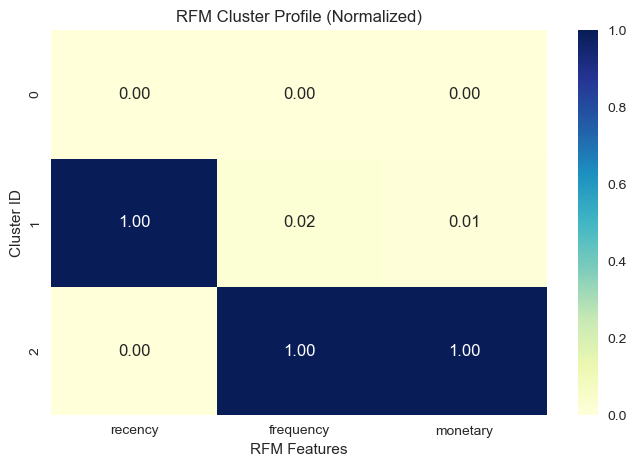

In [362]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Calculate the mean values per cluster
cluster_avg = rfm_no_outliers.groupby('Cluster_Id')[['recency', 'frequency', 'monetary']].mean()

# Step 2: Normalize the values for heatmap readability (0–1 scale)
cluster_avg_normalized = cluster_avg.copy()
for column in cluster_avg.columns:
    cluster_avg_normalized[column] = (cluster_avg[column] - cluster_avg[column].min()) / (cluster_avg[column].max() - cluster_avg[column].min())

# Step 3: Plot the heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(cluster_avg_normalized, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("RFM Cluster Profile (Normalized)")
plt.ylabel("Cluster ID")
plt.xlabel("RFM Features")
plt.show()


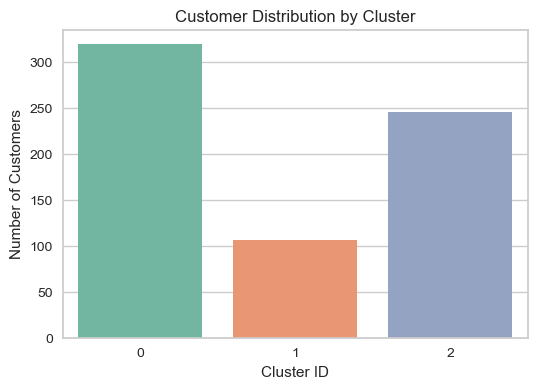

In [363]:
# Bar plot of customer count per cluster
plt.figure(figsize=(6, 4))
sns.countplot(x='Cluster_Id', data=rfm_no_outliers, hue='Cluster_Id', palette='Set2', legend=None)
plt.title('Customer Distribution by Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Customers')
plt.show()


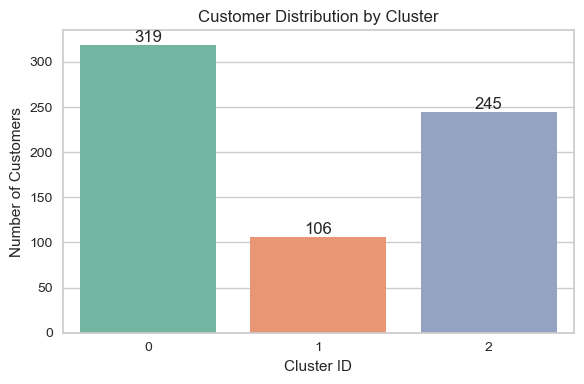

In [364]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Cluster_Id', data=rfm_no_outliers, palette='Set2', hue='Cluster_Id', legend=False)
plt.title('Customer Distribution by Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Customers')

# Add labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,  # x-position (center of bar)
        height + 3,                      # y-position (a bit above the bar)
        f'{int(height)}',                # label text
        ha='center'
    )

plt.tight_layout()
plt.show()


In [ ]:
# cluster_avg_normalized.index = ['Loyal Mid-Spenders', 'At-Risk Customers', 'Best Customers']


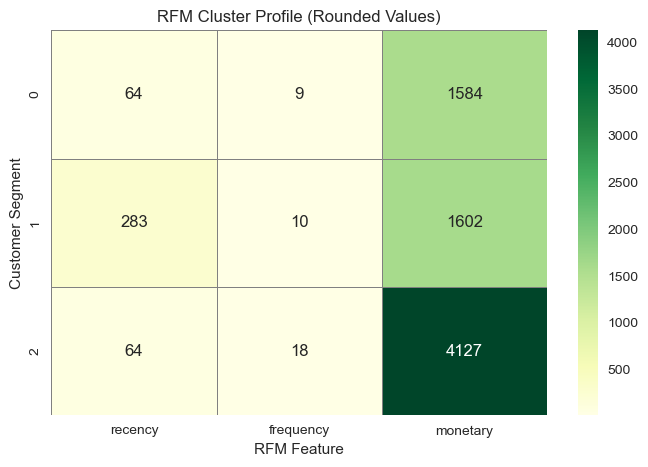

In [376]:
# Round values to integers and convert to string
annot_labels = cluster_avg.round(0).astype(int).astype(str)

# # Define a gradient from light grey → yellow → red
# colors = ["#f7fcf5", "#c7e9c0", "#74c476", "#238b45"]  # light to dark green
# custom_cmap = LinearSegmentedColormap.from_list("green_pos", colors, N=256)

plt.figure(figsize=(8, 5))
sns.heatmap(
    cluster_avg,
    annot=annot_labels,
    cmap='YlGn',
    fmt='',
    cbar=True,
    linewidths=0.5,
    linecolor='gray'
)
plt.title("RFM Cluster Profile (Rounded Values)")
plt.ylabel("Customer Segment")
plt.xlabel("RFM Feature")
plt.show()


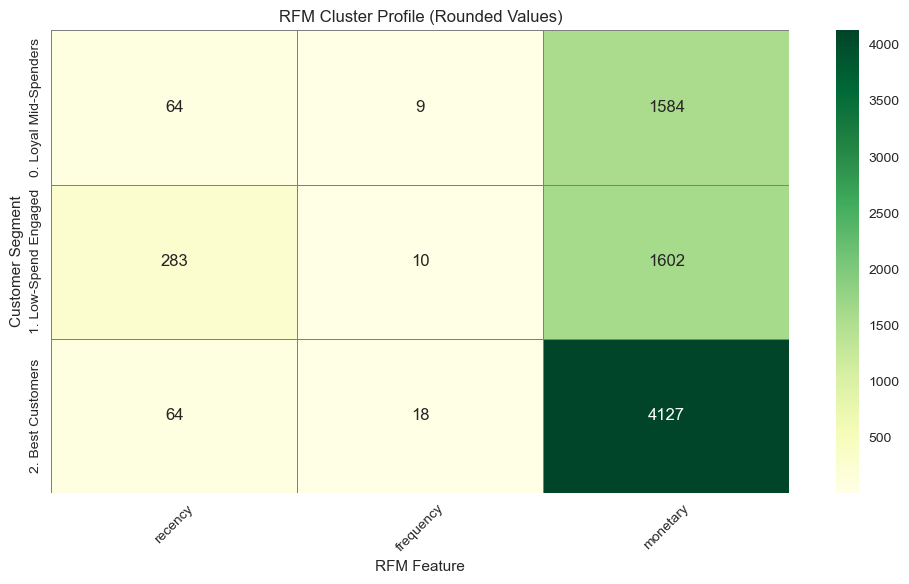

In [377]:
# Step 1: rename cluster_avg index
cluster_avg_named = cluster_avg.copy()
cluster_avg_named.index = cluster_avg_named.index.map(cluster_id_to_name)

# Step 2: create annot_labels from cluster_avg_named (same index and shape)
annot_labels_named = cluster_avg_named.round(0).astype(int).astype(str)

# Step 3: plot heatmap with matching annot
plt.figure(figsize=(10, 6))
sns.heatmap(
    cluster_avg_named,
    annot=annot_labels_named,
    cmap='YlGn',
    fmt='',
    cbar=True,
    linewidths=0.5,
    linecolor='gray'
)
plt.title("RFM Cluster Profile (Rounded Values)")
plt.ylabel("Customer Segment")
plt.xlabel("RFM Feature")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


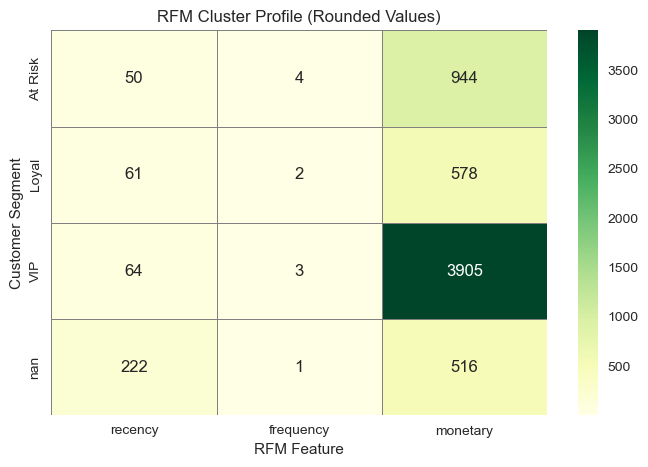

In [ ]:
# # Map cluster IDs to descriptive names for the y-axis
# cluster_id_to_name = {0: "At Risk", 1: "Loyal", 2: "VIP"}
# cluster_avg_named = cluster_avg.copy()
# cluster_avg_named.index = cluster_avg_named.index.map(cluster_id_to_name)

# plt.figure(figsize=(8, 5))
# sns.heatmap(
#     cluster_avg_named,
#     annot=annot_labels.set_index(cluster_avg_named.index),
#     cmap='YlGn',
#     fmt='',
#     cbar=True,
#     linewidths=0.5,
#     linecolor='gray'
# )
# plt.title("RFM Cluster Profile (Rounded Values)")
# plt.ylabel("Customer Segment")
# plt.xlabel("RFM Feature")
# plt.show()

In [369]:
# Count the number of customers in each group (Cluster_Id) for 2017
customer_counts_2017 = rfm_no_outliers.groupby('Cluster_Id')['CustomerID'].nunique().reset_index()
customer_counts_2017.columns = ['Cluster_Id', 'num_customers']
print(customer_counts_2017)

   Cluster_Id  num_customers
0           0            319
1           1            106
2           2            245


## Dimensional Visualizations

In [370]:
fig = make_subplots(rows=1, cols=3)

fig.add_trace(
    go.Scatter(
        x=rfm_no_outliers["recency"], 
        y=rfm_no_outliers["frequency"], 
        mode="markers"
    ),
    row=1, col=1,
)

fig.update_xaxes(title_text="recency", row=1, col=1)
fig.update_yaxes(title_text="frequency", row=1, col=1)

fig.add_trace(
    go.Scatter(
        x=rfm_no_outliers["recency"], 
        y=rfm_no_outliers["monetary"], 
        mode="markers"
    ),
    row=1, col=2
)

fig.update_xaxes(title_text="recency", row=1, col=2)
fig.update_yaxes(title_text="monetary", row=1, col=2)

fig.add_trace(
    go.Scatter(
        x=rfm_no_outliers["frequency"], 
        y=rfm_no_outliers["monetary"], 
        mode="markers"
    ),
    row=1, col=3
)

fig.update_xaxes(title_text="frequency", row=1, col=3)
fig.update_yaxes(title_text="monetary", row=1, col=3)

In [381]:
import plotly.express as px

# Make sure Segment column is mapped to your 3 clusters:
cluster_map = {
    2: 'Best Customers',
    0: 'Loyal Mid-Spenders',
    1: 'Low-Spend Engaged'
}
rfm_no_outliers['Segment'] = rfm_no_outliers['Cluster_Id'].map(cluster_map)

# 3D scatter plot with updated clusters and segment names
fig_3d = px.scatter_3d(
    rfm_no_outliers,
    x="recency",
    y="frequency",
    z="monetary",
    color="Segment",           # Use the updated segment names for colors
    symbol="Cluster_Id",       # Use cluster IDs for different marker shapes
    hover_data=["CustomerID", "recency", "frequency", "monetary"],
    width=700,
    height=550,
    opacity=0.8
)

fig_3d.update_traces(marker=dict(size=6))

fig_3d.update_layout(
    title="3D Scatter Plot of RFM Segments (3 Clusters)",
    legend_title="Customer Segment",
    scene=dict(
        xaxis_title="Recency (days)",
        yaxis_title="Frequency",
        zaxis_title="Monetary Value"
    )
)

fig_3d.show()


In [382]:
import plotly.express as px

# Map Cluster_Id to Segment names
cluster_map = {
    2: 'Best Customers',
    0: 'Loyal Mid-Spenders',
    1: 'Low-Spend Engaged'
}
rfm_no_outliers['Segment'] = rfm_no_outliers['Cluster_Id'].map(cluster_map)

# Create bigger 3D scatter plot
fig_3d = px.scatter_3d(
    rfm_no_outliers,
    x="recency",
    y="frequency",
    z="monetary",
    color="Segment",
    symbol="Cluster_Id",
    hover_data=["CustomerID", "recency", "frequency", "monetary"],
    width=1000,   # bigger width
    height=800,   # bigger height
    opacity=0.8
)

fig_3d.update_traces(marker=dict(size=8))  # larger markers

fig_3d.update_layout(
    title="3D Scatter Plot of RFM Segments (3 Clusters)",
    legend_title="Customer Segment",
    scene=dict(
        xaxis_title="Recency (days)",
        yaxis_title="Frequency",
        zaxis_title="Monetary Value"
    )
)

# Save to HTML file
fig_3d.write_html("rfm_3d_scatter_plot.html")

# Show plot in notebook or interactive environment
fig_3d.show()


In [384]:
import plotly.express as px

# Step 1: Use your preferred segment names
segment_map = {
    2: "2. Best Customers",
    0: "0. Loyal Mid-Spenders",
    1: "1. Low-Spend Engaged",
    3: "3. At-Risk Customers"
}
rfm_no_outliers["Segment"] = rfm_no_outliers["Cluster_Id"].map(segment_map)

# Step 2: Define matching color map
color_map = {
    "2. Best Customers": "green",
    "0. Loyal Mid-Spenders": "royalblue",
    "1. Low-Spend Engaged": "goldenrod",
    "3. At-Risk Customers": "crimson"
}

# Step 3: Create the 3D scatter plot
fig_3d = px.scatter_3d(
    rfm_no_outliers,
    x="recency",
    y="frequency",
    z="monetary",
    color="Segment",
    symbol="Cluster_Id",
    hover_data=["CustomerID", "recency", "frequency", "monetary"],
    color_discrete_map=color_map,
    width=900,
    height=700,
    opacity=0.7
)

# Step 4: Customize hover template and marker size
fig_3d.update_traces(
    marker=dict(size=5),
    hovertemplate="<b>Customer ID:</b> %{customdata[0]}<br>"
                  "<b>Recency:</b> %{x}<br>"
                  "<b>Frequency:</b> %{y}<br>"
                  "<b>Monetary:</b> %{z}<br>"
                  "<extra></extra>"
)

# Step 5: Update layout and axis labels
fig_3d.update_layout(
    title="3D Scatter Plot of RFM Segments (3 Clusters)",
    legend_title="Customer Segment",
    scene=dict(
        xaxis_title="Recency (days)",
        yaxis_title="Frequency",
        zaxis_title="Monetary Value"
    )
)

fig_3d.show()


# Save the interactive plot to an HTML file
fig_3d.write_html("rfm_3d_clusters_3_segments.html")


## Clusters by years

In [385]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'])
df['Year'] = df['OrderDate'].dt.year


In [391]:
# Replace comma with dot if comma is decimal separator, else remove thousands separators
# Here, try to replace ',' with '.' and then convert:

df['Sales'] = df['Sales'].str.replace(',', '.', regex=False)

# Convert to numeric, forcing errors to NaN (if any malformed strings)
df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')

# Check for NaNs introduced
print(df['Sales'].isna().sum())



0


In [394]:
df['Sales'] = df['Sales'].astype(str).str.replace(',', '.', regex=False)
df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')


In [395]:
print(df['Sales'].dtype)  # should be float64 or int64
print(df['Sales'].head())


float64
0    261.9600
1    731.9400
2     14.6200
3    957.5775
4     22.3680
Name: Sales, dtype: float64


In [397]:
rfm_yearly = []

for year in sorted(df['Year'].unique()):
    yearly_df = df[df['Year'] == year]
    
    snapshot_date = yearly_df['OrderDate'].max() + pd.Timedelta(days=1)
    
    # Aggregate sales per order if multiple rows per order exist (optional)
    sales_per_order = yearly_df.groupby(['OrderID', 'CustomerID']).agg({
        'Sales': 'sum',
        'OrderDate': 'max'
    }).reset_index()
    
    rfm = sales_per_order.groupby('CustomerID').agg({
        'OrderDate': lambda x: (snapshot_date - x.max()).days,
        'OrderID': 'nunique',
        'Sales': 'sum'
    }).reset_index()
    
    rfm.columns = ['CustomerID', 'recency', 'frequency', 'monetary']
    rfm['year'] = year
    rfm_yearly.append(rfm)

rfm_all_years = pd.concat(rfm_yearly, ignore_index=True)
rfm_all_years.head()

,CustomerID,recency,frequency,monetary,year
0,AA-10315,108,2,756.048,2014
1,AA-10375,69,2,50.792,2014
2,AA-10480,242,1,27.460,2014
3,AA-10645,31,2,1434.330,2014
4,AB-10015,300,2,322.216,2014


### Scale, Outlier Removal and Cluster by Year

In [398]:
results = []

for year in rfm_all_years['year'].unique():
    rfm = rfm_all_years[rfm_all_years['year'] == year].copy()
    
    # 1. Remove outliers from raw RFM columns before scaling
    def remove_outliers(df, cols, lower_q=0.01, upper_q=0.99):
        for col in cols:
            lower = df[col].quantile(lower_q)
            upper = df[col].quantile(upper_q)
            df = df[(df[col] >= lower) & (df[col] <= upper)]
        return df
    
    rfm_no_outliers = remove_outliers(rfm, ['recency', 'frequency', 'monetary'])
    
    # 2. Scale RFM values (on outlier-removed data)
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm_no_outliers[['recency', 'frequency', 'monetary']])
    
    # 3. Cluster on scaled data
    kmeans = KMeans(n_clusters=4, random_state=42)
    rfm_no_outliers['Cluster_Id'] = kmeans.fit_predict(rfm_scaled)
    
    # 4. Keep year column for later aggregation and visualization
    rfm_no_outliers['year'] = year
    
    results.append(rfm_no_outliers)

# Concatenate all years back together
rfm_clustered = pd.concat(results)



### Summarize Cluster Profiles

In [399]:
summary = rfm_clustered_all_years.groupby(['year', 'Cluster_Id']).agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'CustomerID': 'count'
}).reset_index().rename(columns={'CustomerID': 'num_customers'})


### Visualize Cluster Trends Over Time

In [188]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Ensure year is an integer for correct x-axis behavior
# summary['year'] = summary['year'].astype(int)

# plt.figure(figsize=(12, 6))
# sns.lineplot(data=summary, x='year', y='monetary', hue='Cluster_Id', marker='o')
# plt.title("Cluster Monetary Value Over Time")
# plt.ylabel("Average Monetary Value")
# plt.xlabel("Year")
# plt.xticks(sorted(summary['year'].unique()))
# plt.grid(True)
# plt.show()


In [274]:
# For each year, rank clusters by average monetary value (descending)
summary['monetary_rank'] = summary.groupby('year')['monetary'] \
                                  .rank(method='first', ascending=False)


In [402]:
def assign_segment(rank):
    if rank == 1:
        return 'Best Customers'
    elif rank == 2:
        return 'Loyal Mid-Spenders'
    elif rank == 3:
        return 'Low-Spend Engaged'
    

if 'monetary_rank' not in summary.columns:
    summary['monetary_rank'] = summary.groupby('year')['monetary'] \
                                      .rank(method='first', ascending=False)

summary['Segment'] = summary['monetary_rank'].apply(assign_segment)



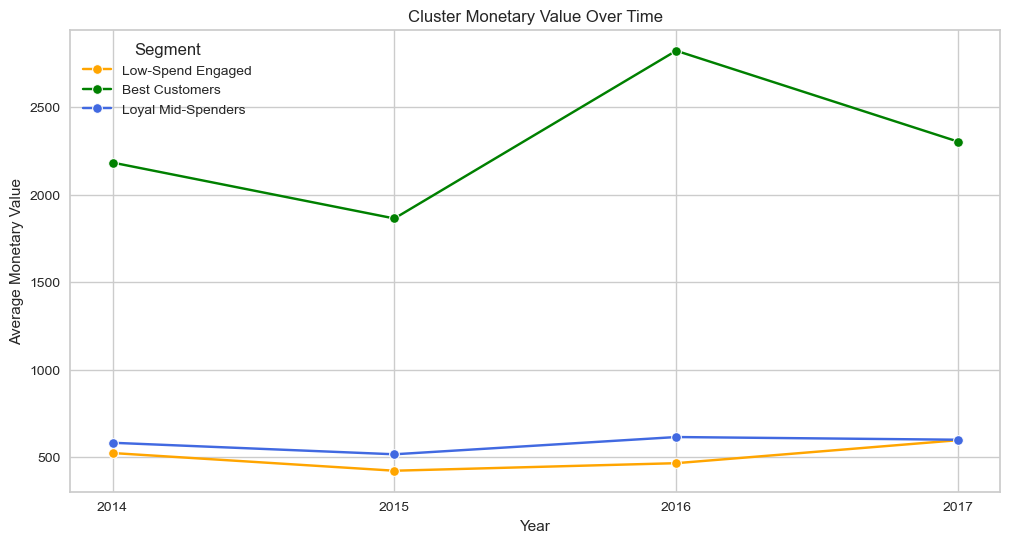

In [403]:
# Ensure 'Segment' column exists in summary
if 'Segment' not in summary.columns:
    def assign_segment(rank):
        if rank == 1:
            return 'Best Customers'
        elif rank == 2:
            return 'Loyal Mid-Spenders'
        elif rank == 3:
            return 'Low-Spend Engaged'
        else:
            return 'At-Risk Customers'
    if 'monetary_rank' not in summary.columns:
        summary['monetary_rank'] = summary.groupby('year')['monetary'] \
                                          .rank(method='first', ascending=False)
    summary['Segment'] = summary['monetary_rank'].apply(assign_segment)

# Drop existing Segment_x and Segment_y columns to avoid merge conflicts
rfm_clustered = rfm_clustered.drop(columns=[col for col in rfm_clustered.columns if col in ['Segment_x', 'Segment_y']], errors='ignore')

# Merge segment labels back into the clustered RFM dataframe
rfm_clustered = rfm_clustered.merge(
    summary[['year', 'Cluster_Id', 'Segment']],
    on=['year', 'Cluster_Id'],
    how='left'
)

# Plot average monetary value over years by segment
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=summary,
    x='year',
    y='monetary',
    hue='Segment',
    marker='o',
    palette={
        'Best Customers': 'green',
        'Loyal Mid-Spenders': 'royalblue',
        'Low-Spend Engaged': 'orange',
        'At-Risk Customers': 'crimson'
    }
)
plt.title("Cluster Monetary Value Over Time")
plt.ylabel("Average Monetary Value")
plt.xlabel("Year")
plt.xticks(sorted(summary['year'].unique()))
plt.grid(True)
plt.legend(title='Segment')
plt.show()


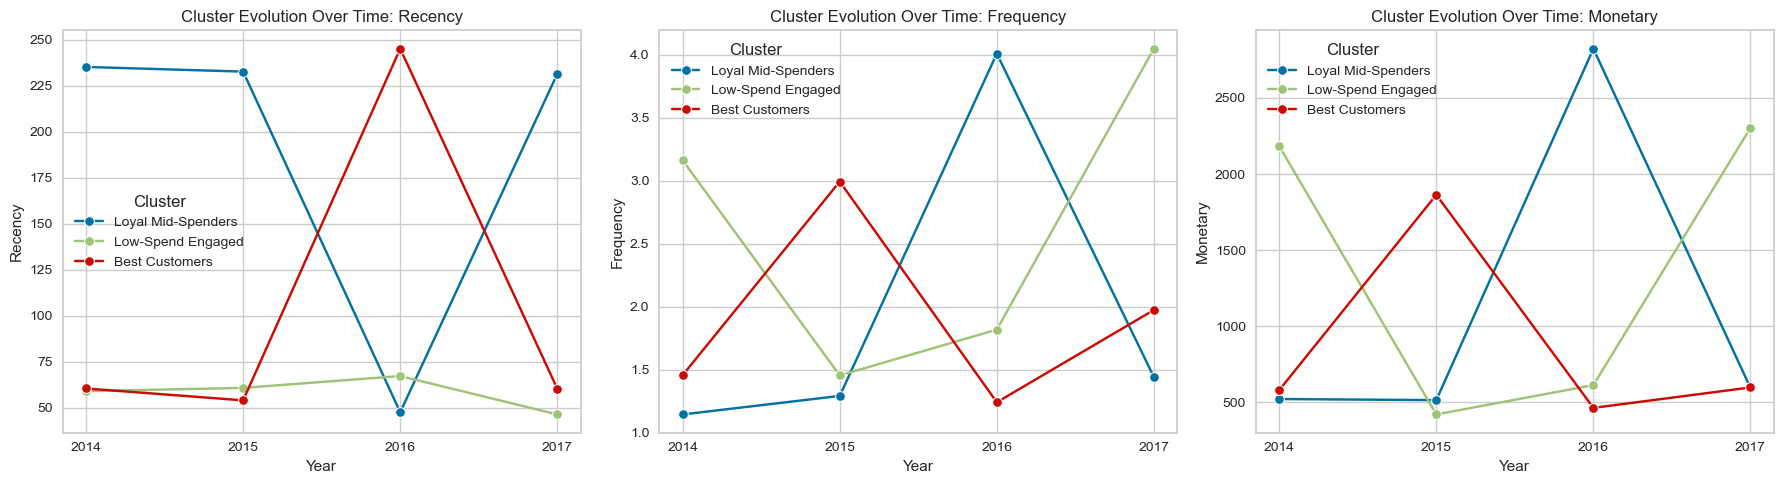

In [416]:
import numpy as np

# Aggregate data by year and cluster to get mean values for each feature
cluster_yearly_avg = rfm_clustered_all_years.groupby(['year', 'Cluster_Id'])[['recency', 'frequency', 'monetary']].mean().reset_index()

# Convert year to int to avoid decimal points on x-axis
cluster_yearly_avg['year'] = cluster_yearly_avg['year'].astype(int)

# Cluster names for legend (adapt if needed)
cluster_names = {
    0: "Loyal Mid-Spenders",
    1: "Low-Spend Engaged",
    2: "Best Customers"
}

# Map cluster names
cluster_yearly_avg['Cluster_Name'] = cluster_yearly_avg['Cluster_Id'].map(cluster_names)

# Features to plot
features = ['recency', 'frequency', 'monetary']

# Create subplots: one per feature
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

years = sorted(cluster_yearly_avg['year'].unique())  # get sorted unique years

for i, feature in enumerate(features):
    ax = axes[i]
    sns.lineplot(
        data=cluster_yearly_avg,
        x='year',
        y=feature,
        hue='Cluster_Name',
        marker='o',
        ax=ax
    )
    ax.set_title(f'Cluster Evolution Over Time: {feature.capitalize()}')
    ax.set_xlabel('Year')
    ax.set_ylabel(feature.capitalize())
    ax.legend(title='Cluster')
    ax.grid(True)

    # Force integer ticks on x-axis
    ax.set_xticks(years)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))

plt.tight_layout()
plt.show()



C:\Users\raclo\AppData\Local\Temp\ipykernel_21564\3330203915.py:27: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


C:\Users\raclo\AppData\Local\Temp\ipykernel_21564\3330203915.py:27: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


C:\Users\raclo\AppData\Local\Temp\ipykernel_21564\3330203915.py:27: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




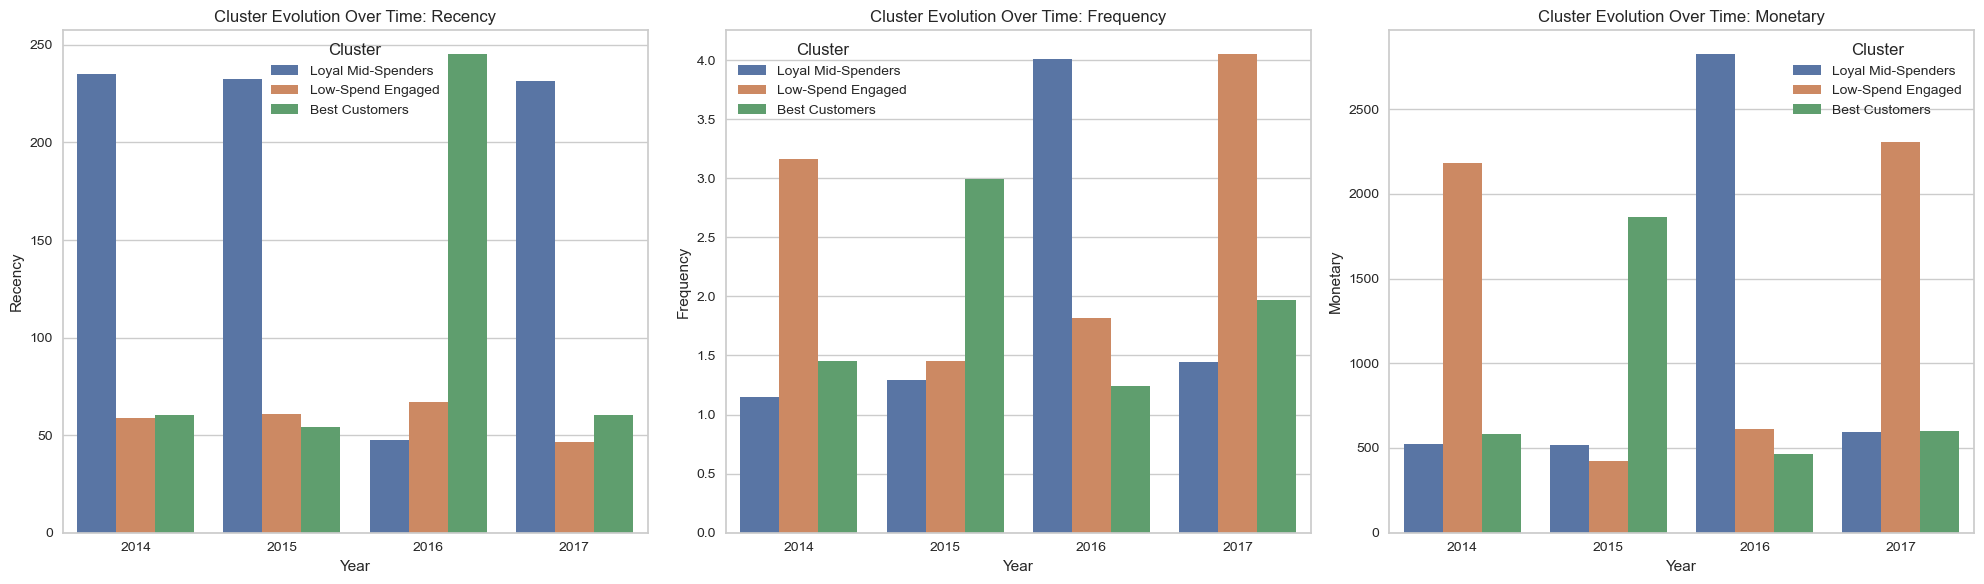

In [420]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming cluster_yearly_avg is prepared as before

features = ['recency', 'frequency', 'monetary']
years = sorted(cluster_yearly_avg['year'].unique())
cluster_names = {
    0: "Loyal Mid-Spenders",
    1: "Low-Spend Engaged",
    2: "Best Customers"
}
cluster_yearly_avg['Cluster_Name'] = cluster_yearly_avg['Cluster_Id'].map(cluster_names)

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True)

palette = ["#4c72b0",  # muted blue
           "#dd8452",  # muted orange
           "#55a868"]  # muted green


for i, feature in enumerate(features):
    ax = axes[i]
    
    # Create a barplot with hue=Cluster_Name, grouped by year
    sns.barplot(
        data=cluster_yearly_avg,
        x='year',
        y=feature,
        hue='Cluster_Name',
        ax=ax,
        ci=None,
        palette=palette
    )
    
    ax.set_title(f'Cluster Evolution Over Time: {feature.capitalize()}')
    ax.set_xlabel('Year')
    ax.set_ylabel(feature.capitalize())
    ax.grid(True, axis='y')
    ax.legend(title='Cluster')
    
    # Force integer ticks on x-axis
    ax.set_xticks(range(len(years)))
    ax.set_xticklabels(years)

plt.tight_layout()
plt.show()


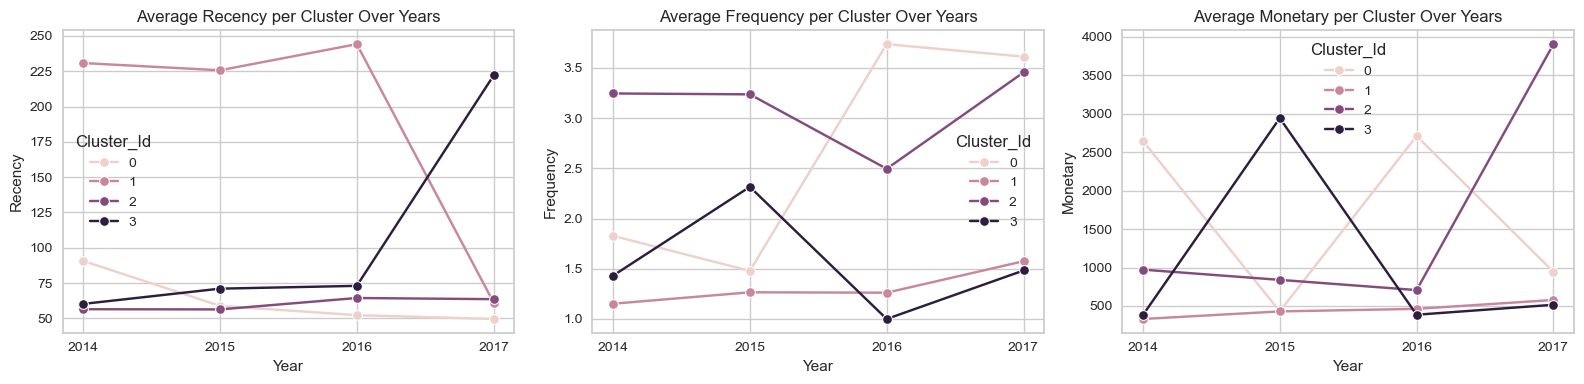

In [406]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate metrics by year and cluster
summary = rfm_clustered.groupby(['year', 'Cluster_Id']).agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'num_customers'}).reset_index()

# Plot each metric over years with one line per cluster
plt.figure(figsize=(16, 4))

for i, metric in enumerate(['recency', 'frequency', 'monetary']):
    plt.subplot(1, 3, i+1)
    sns.lineplot(data=summary, x='year', y=metric, hue='Cluster_Id', marker='o')
    plt.title(f'Average {metric.capitalize()} per Cluster Over Years')
    plt.ylabel(metric.capitalize())
    plt.xlabel('Year')
    plt.grid(True)
    # Ensure x-axis ticks are integer years
    plt.xticks(sorted(summary['year'].unique()))
plt.tight_layout()
plt.show()
